<a href="https://colab.research.google.com/github/anmo1987/Final_project_Artefact/blob/main/Copy_of_Image_Analysis_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

##Import librairies

In [2]:
###Import libraries
import os
import pandas as pd
from PIL import Image
import numpy as np
import random
import seaborn as sns
##from sklearn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

### sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.metrics import classification_report, accuracy_score
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier

### tensorflow
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras import layers, models
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D, Conv2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator



##1. IMPORT DATASET FROM KAGGLE
SKIN CANCER DATASET (https://www.kaggle.com/datasets/farjanakabirsamanta/skin-cancer-dataset)

In [6]:
###IMPORT DATASET TO GOOGLE COLLAB
###Download API token from kaggle and store the .json file to content folder
!pip install kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
##import data csv
!unzip skin-cancer-mnist-ham10000.zip -d /content/skin_cancer_dataset
y

mv: cannot stat 'kaggle.json': No such file or directory
skin-cancer-mnist-ham10000.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  skin-cancer-mnist-ham10000.zip
replace /content/skin_cancer_dataset/HAM10000_images_part_1/ISIC_0024306.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [3]:
##MOVE ALL PICTURES IN THE SAME DIR
!mv /content/skin_cancer_dataset/HAM10000_images_part_2/*.jpg /content/skin_cancer_dataset/HAM10000_images_part_1/
#REMOVE FOLDERS
!rm -r /content/skin_cancer_dataset/ham10000_images_part_2
!rm -r /content/skin_cancer_dataset/ham10000_images_part_1
!rm -r /content/skin_cancer_dataset/HAM10000_images_part_2/



In [8]:
###cHECK IMPORTED DATA
project_dir = '/content/skin_cancer_dataset/'
image_dir = '/content/skin_cancer_dataset/HAM10000_images_part_1'
# Create lists to store image arrays and labels
!ls -la $image_dir/*jpg | wc -l

10015


###1.1 IMPORT DATA TO NOTEBOOK FOR ANALYSIS
Two files to be imported, a csv file and 10015 images in .jpg

#### The CSV dataset

In [22]:
###Import images into Dataframe
data = pd.read_csv('/content/skin_cancer_dataset/HAM10000_metadata.csv')
data['image_id_ext'] = data["image_id"] + '.jpg'
data

,lesion_id,image_id,dx,dx_type,age,sex,localization,image_id_ext
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,ISIC_0031633.jpg
...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,ISIC_0033084.jpg
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,ISIC_0033550.jpg
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,ISIC_0033536.jpg
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,ISIC_0032854.jpg


In [10]:
##Look the data structure
data = data.sort_values(by=['image_id'])

In [23]:
##Transform y categorical to numeric
# Handling categorical data
encoder = LabelEncoder()
data["dx_label"] = encoder.fit_transform(data["dx"])

# Print new labels and correspondances
print("Cancer types and their integer encoding")
print(encoder.classes_)
print(encoder.transform(encoder.classes_))

Cancer types and their integer encoding
['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']
[0 1 2 3 4 5 6]


DISPLAY ONE IMAGE AND LOOKING FOR SHAPE

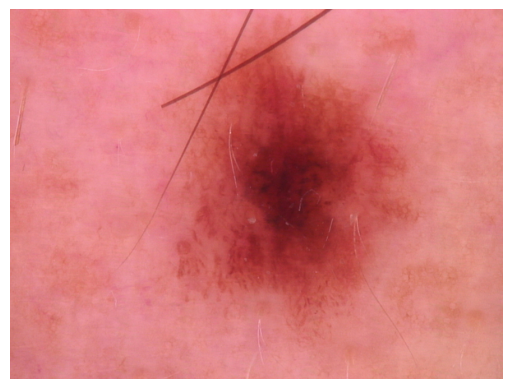

In [11]:
##DISPLAY A SINGLE IMAGE
##View image
from matplotlib import  pyplot as plt
import matplotlib.image as mpimg
import glob

img = mpimg.imread('/content/skin_cancer_dataset/HAM10000_images/ISIC_0024306.jpg')
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()

In [12]:
#Check image shape
img.shape

(450, 600, 3)

#### IMPORT ALL PICTURES IN A FILE IN FORMAT 28,28,3

In [38]:
%%time
##IMPORT ALL IMAGES IN A FILES and resized them in 28 / 28
dataset_directory = '/content/skin_cancer_dataset/HAM10000_images'
images = []
labels = []
flattened_images = []

for image_filename in os.listdir(dataset_directory):
    image_path = os.path.join(dataset_directory, image_filename)

    # Read and preprocess the image (resize 28 28)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB format
    img = cv2.resize(img, (28, 28))  # Resize the image to a common size
    img_scaled = img/255.0

    # Extract the label from the filename
    label = image_filename.split('.')[0]
    flattened_image = img_scaled.reshape(-1)

    # Append the image and its label to the lists.
    images.append(img)
    labels.append(label)
    flattened_images.append(flattened_image)

flattened_images = np.array(flattened_images)
images = np.array(images)
labels = np.array(labels)




CPU times: user 1min 50s, sys: 7.53 s, total: 1min 58s
Wall time: 2min 33s


In [40]:
##Looking at the shape of the created files
flattened_images.shape, images.shape, labels.shape

((10015, 2352), (10015, 28, 28, 3), (10015,))

In [42]:
###create the y value from csv and labels array
# Create a dictionary to map image IDs to dx_labels.
image_id_to_dx_label = dict(zip(data['image_id'], data['dx_label']))
dx_labels = np.array([image_id_to_dx_label.get(image_id, -1) for image_id in labels])
y = dx_labels

In [43]:
len(y)

10015

In [44]:
##saved flattened images size 28 * 28
df = pd.DataFrame(flattened_images)
df["y"] = y
df["labels_id"] = labels
df.to_csv("/content/skin_cancer_dataset/image_scaled_flatten.csv")


In [45]:
df

,0,1,2,3,4,5,6,7,8,9,...,2344,2345,2346,2347,2348,2349,2350,2351,y,labels_id
0,0.870588,0.756863,0.862745,0.909804,0.835294,0.909804,0.929412,0.843137,0.921569,0.921569,...,0.831373,0.890196,0.874510,0.768627,0.854902,0.901961,0.827451,0.909804,2,ISIC_0033629
1,0.835294,0.752941,0.756863,0.866667,0.800000,0.788235,0.870588,0.831373,0.870588,0.882353,...,0.843137,0.862745,0.886275,0.827451,0.823529,0.886275,0.839216,0.858824,4,ISIC_0030211
2,0.898039,0.556863,0.686275,0.901961,0.603922,0.686275,0.921569,0.631373,0.717647,0.901961,...,0.517647,0.603922,0.835294,0.533333,0.615686,0.827451,0.545098,0.580392,5,ISIC_0024859
3,0.796078,0.658824,0.662745,0.800000,0.662745,0.662745,0.831373,0.709804,0.705882,0.815686,...,0.447059,0.486275,0.596078,0.462745,0.513725,0.513725,0.360784,0.372549,1,ISIC_0025530
4,0.682353,0.643137,0.768627,0.678431,0.627451,0.721569,0.686275,0.631373,0.701961,0.717647,...,0.588235,0.603922,0.643137,0.576471,0.560784,0.639216,0.576471,0.607843,5,ISIC_0032957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10010,0.945098,0.596078,0.639216,0.945098,0.592157,0.658824,0.937255,0.592157,0.654902,0.952941,...,0.666667,0.623529,0.933333,0.647059,0.623529,0.913725,0.647059,0.607843,5,ISIC_0026495
10011,0.635294,0.427451,0.376471,0.643137,0.415686,0.333333,0.643137,0.364706,0.329412,0.654902,...,0.435294,0.431373,0.552941,0.415686,0.403922,0.439216,0.286275,0.223529,1,ISIC_0028323
10012,0.960784,0.658824,0.737255,0.960784,0.678431,0.756863,0.952941,0.635294,0.717647,0.956863,...,0.627451,0.658824,0.905882,0.619608,0.639216,0.850980,0.600000,0.615686,5,ISIC_0028501
10013,0.882353,0.572549,0.600000,0.894118,0.560784,0.592157,0.870588,0.568627,0.588235,0.878431,...,0.533333,0.545098,0.807843,0.517647,0.513725,0.772549,0.498039,0.478431,5,ISIC_0024533


###1.2 RESTART FROM IMAGES FLATTEN CSV FILE

In [ ]:
###IF WE WANT TO RESTART FROM THE FLATTEN CSV FILE
# Load the CSV file containing flattened image data and labels.
df = pd.read_csv('/content/image_scaled_flatten.csv')

# Extract flattened image data and labels.
y = np.array(df["y"])
labels = np.array(df["labels_id"])
df = df.drop('Unnamed: 0', axis=1)
df = df.drop('labels_id', axis=1)
df = df.drop('y', axis=1)

# Reshape flattened image data back to original dimensions (assuming 224x224x3).

original_shape = (len(df), 28, 28, 3)
array_data = df.to_numpy()
images_from_csv = array_data.reshape(original_shape)
images_from_csv.shape, y.shape, labels.shape, df.shape


In [28]:
##Look out the shape for the two files

print(f'Images downloaded shape : {images.shape}\n Labels shape : {labels.shape}\n Flatten images scaled shae : {flattened_images.shape}')

Images downloaded shape : (10015, 28, 28, 3)
 Labels shape : (10015,)
 Flatten images scaled shae : (10015, 2352)


##2. CNN DATA ANALYSIS


###2.1 VISUALIZATION OF THE 7 CLASSES OF SKIN DISEASES

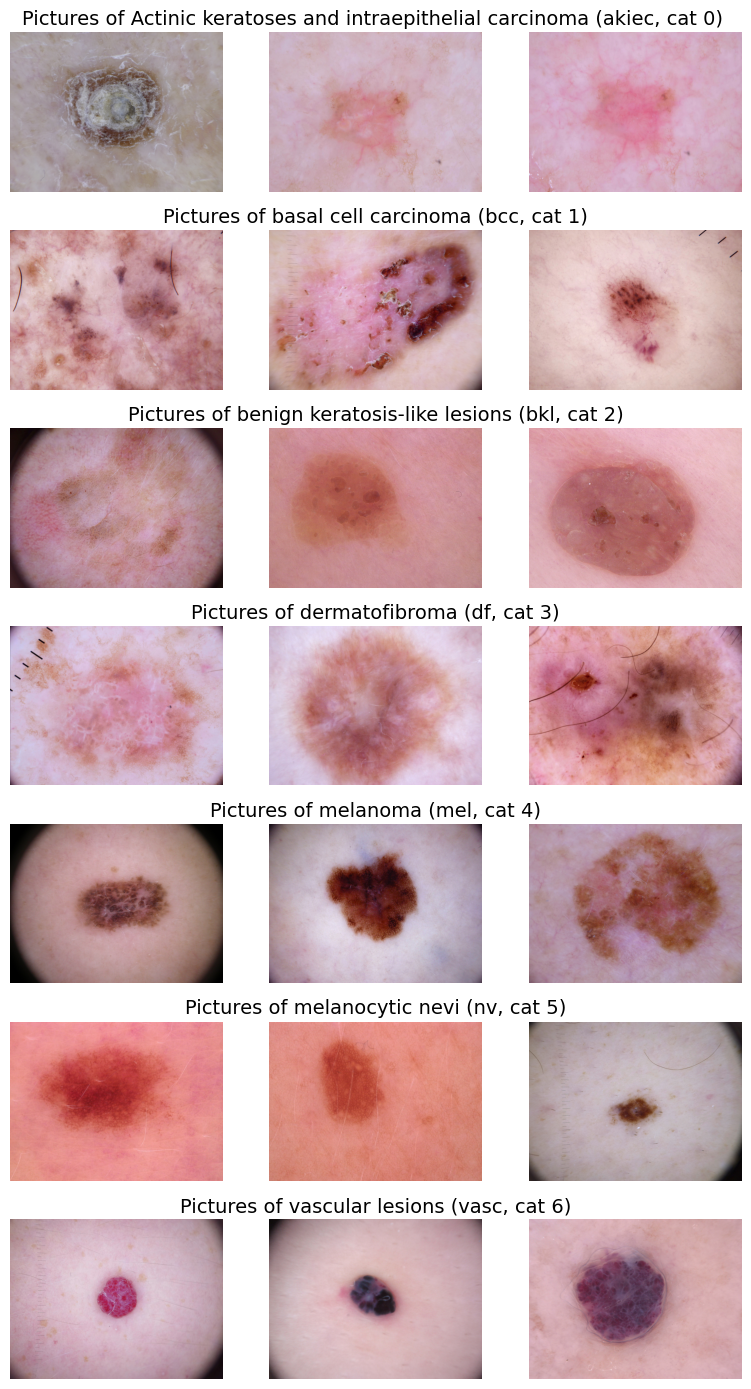

<Figure size 640x480 with 0 Axes>

In [70]:
# Create a dictionary to store two random image filenames from each category.
category_images = {}
num_categories = 5  # Assuming you have 7 categories.
image_dir = '/content/skin_cancer_dataset/HAM10000_images'
# Collect two random image filenames from each category.
# Create a dictionary to store two random image filenames from each category.
category_images = {}
num_categories = 7  # Assuming you have 7 categories.

# Collect two random image filenames from each category.
for category in range(num_categories):
    category_data = data[data['dx_label'] == category]
    image_filenames = category_data['image_id_ext'].tolist()

    # Shuffle the image filenames to get random samples.
    random.shuffle(image_filenames)

    # Get the first two images from each category.
    random_images = image_filenames[:3]
    category_images[category] = random_images

# Get the corresponding category names for plotting.
category_names = {
    0: 'Pictures of Actinic keratoses and intraepithelial carcinoma (akiec, cat 0) ',
    1: 'Pictures of basal cell carcinoma (bcc, cat 1)',
    2: 'Pictures of benign keratosis-like lesions (bkl, cat 2)',
    3: 'Pictures of dermatofibroma (df, cat 3)',
    4: 'Pictures of melanoma (mel, cat 4)',
    5: 'Pictures of melanocytic nevi (nv, cat 5)',
    6: 'Pictures of vascular lesions (vasc, cat 6)'
}

# Plot the two images from each category.
fig, axes = plt.subplots(num_categories, 3, figsize=(8, 2 * num_categories))

for i, category in enumerate(range(num_categories)):
    for j in range(3):
        image_filename = category_images[category][j]
        image_path = os.path.join(image_dir, image_filename)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB format
        axes[i, j].imshow(img)
        #axes[i, j].set_title(f'{category}: {category_names[category]}')
        axes[i, j].axis('off')

    axes[i, 1].set_title(f'{category_names[category]}', fontsize=14)


plt.tight_layout()
plt.show()
plt.savefig('Skin_diseases.jpg', format='jpg')

In [48]:
###download file
from google.colab import files
files.download('/content/skin_cancer_dataset/image_scaled_flatten.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [49]:
##check if we have the same values by categories in y & data
unique_labels, label_counts = np.unique(y, return_counts=True)
label_count_dict = dict(zip(unique_labels, label_counts))

# Print the counts for each unique label.
for label, count in label_count_dict.items():
    print(f"Label: {label}, Count: {count}")
print(data["dx_label"].value_counts())

Label: 0, Count: 327
Label: 1, Count: 514
Label: 2, Count: 1099
Label: 3, Count: 115
Label: 4, Count: 1113
Label: 5, Count: 6705
Label: 6, Count: 142
5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: dx_label, dtype: int64


###2.2 Prepare Dataset for CNN

In [50]:
##Scale the images
##Image in dimension 224, 224,3 with pixel value from 1 to 255
images_scaled =  images/255

In [123]:
##SPLIT DATASET IN TRAIN & TEST
# Step 2: Split the Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(images_from_csv, y, stratify= y, test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8012, 28, 28, 3), (8012,), (2003, 28, 28, 3), (2003,))

In [52]:
##look for ratio categorical in train & test
# Calculate the unique labels and their counts in training data.
unique_labels_train, counts_train = np.unique(y_train, return_counts=True)

# Calculate the unique labels and their counts in testing data.
unique_labels_test, counts_test = np.unique(y_test, return_counts=True)

# Create dictionaries to store label counts.
label_counts_train = dict(zip(unique_labels_train, counts_train))
label_counts_test = dict(zip(unique_labels_test, counts_test))

# Print the label counts for training and testing data.
print("Label Counts in Training Data:")
for label, count in label_counts_train.items():
    print(f"Label {label}: {float(count/8012*100):.2f} % samples")

print("\nLabel Counts in Testing Data:")
for label, count in label_counts_test.items():
    print(f"Label {label}: {float(count/2003*100):.2f} % samples")


Label Counts in Training Data:
Label 0: 3.27 % samples
Label 1: 5.13 % samples
Label 2: 10.97 % samples
Label 3: 1.15 % samples
Label 4: 11.11 % samples
Label 5: 66.95 % samples
Label 6: 1.42 % samples

Label Counts in Testing Data:
Label 0: 3.25 % samples
Label 1: 5.14 % samples
Label 2: 10.98 % samples
Label 3: 1.15 % samples
Label 4: 11.13 % samples
Label 5: 66.95 % samples
Label 6: 1.40 % samples


###2.3 CNN Modelling




In [127]:
##Transform y to categorical data
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)
y_train.shape, y_test.shape

((8012, 7), (2003, 7))



####FIRST CNN CLASSICAL MODEL
#####**Model description:**
Model sequential

- Conv2D layer with 32 kernels of size (3,3) & input shape 28,28,3, activation function ReLu
- Maxpooling 2D 2,2
- Conv2D with 64 kernels sized (3,3), activation function ReLu
- Maxpooling 2D 2,2
- Conv2D with 64 kernels sized (3,3), activation function ReLu
- Flatten images
- Dense layers 64 units, ReLu activation function
- Dense layer 7 units, ReLu activation function
- Output Dense Layers, with 7 units for the 7 skin cancers categories and Softmax activation
#####**Model compilation:**
- Compile with adam optimizer, and categorical crossentropy loss, accuracy measured
- early stopping defines with patience 10 on accuracy score
#####**Model run:**
Model ran with batch = 202, 25 epochs


In [121]:
##Build CNN models
def model1():
  model1 = Sequential()
  model1.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(28,28,3)))
  model1.add(MaxPooling2D(pool_size=(2, 2)))
  model1.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
  model1.add(MaxPooling2D(pool_size=(2, 2)))
  model1.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
  model1.add(Flatten())
  model1.add(Dense(84, activation='relu'))
  model1.add(Dense(7, activation='softmax'))
  return model1

model_1 = model1()

In [128]:
##Compile the model
# Compile the model.
model_1.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use categorical cross-entropy for multi-class classification
              metrics=['accuracy'])
# TODO: Compile and fit your model
callback = [EarlyStopping(monitor='accuracy', patience=10)]



In [119]:
##Model summary
model_1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 3, 3, 64)          36928     
                                                                 
 flatten_4 (Flatten)         (None, 576)              

In [ ]:
##Run model
history = model_1.fit(X_train,y_train,
                            validation_data=(X_test,y_test),
                            batch_size = 202,
                            epochs = 25,
                            callbacks = callback)

In [132]:
##Saving the model 1
# Assuming 'model' is your trained CNN model
with open('cnn_model1.pkl', 'wb') as model_file:
    pickle.dump(model_1, model_file)

# Assuming 'model' is your trained CNN model
model_1.save('cnn_mode1.h5')

In [ ]:
###To reimport model

# Load the saved model
with open('cnn_model.pkl', 'rb') as model_file:
    loaded_model = pickle.load(model_file)

# Use the loaded model for prediction
predictions = loaded_model.predict(your_input_data)

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('cnn_model.h5')

# Use the loaded model for prediction
predictions = loaded_model.predict(your_input_data)


####LENET MODEL
####LeNet5 CNN CLASSICAL MODEL
#####**Model description:**
Model sequential
- Conv2D layer with 6 kernels of size (5,5) & input shape 28,28,3, activation function ReLu
- Maxpooling 2D 2,2
- Conv2D with 16 kernels sized (5,5), activation function ReLu
- Maxpooling 2D 2,2
- Flatten images
- Dense layers 120 units, ReLu activation function
- Dense layer 84 units, ReLu activation function
- Output Dense Layers, with 7 units for the 7 skin cancers categories and Softmax activation
#####**Model compilation:**
- Compile with adam optimizer, and categorical crossentropy loss, accuracy measured
- early stopping defines with patience 10 on accuracy score
#####**Model run:**
Model ran with batch = 202, 25 epochs


In [133]:
##trying LeNet model
##built the model
def lenet():
    # Create the Sequential object
    model_LeNet5 = Sequential()
    #1: Convulsion Layer C1
    model_LeNet5.add(Conv2D(filters=6, kernel_size=(5,5), activation='relu', input_shape=(28,28,3), padding='same'))
    #2: Subsampling layer S2 / Maxpooling
    model_LeNet5.add(MaxPooling2D(pool_size=(2, 2)))
    #3: Convultion layer C3
    model_LeNet5.add(Conv2D(filters=16, kernel_size=(5,5), activation='relu'))
    #4: Subsampling layer S4 / Maxpooling
    model_LeNet5.add(MaxPooling2D(pool_size=(2, 2)))
    ##flatten
    model_LeNet5.add(Flatten())
    #5: Dense Layer C5
    model_LeNet5.add(Dense(120, activation='relu', name='LAYER_C5'))
    #6: Full connection layer with Gaussia, kernel
    model_LeNet5.add(Dense(84, activation='relu', name='LAYER_F6'))
    #last neuron with 10 unit because 10y values
    model_LeNet5.add(Dense(7, activation='softmax', name='output_layer'))
    #return created model
    return model_LeNet5
model_LeNet5 = lenet()

In [134]:
##compile LeNet model
# TODO: Compile and fit your model
from tensorflow.keras.callbacks import EarlyStopping
callback = [EarlyStopping(monitor='accuracy', patience=10)]
model_LeNet5.summary()
model_LeNet5.compile(optimizer='adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 28, 28, 6)         456       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 14, 14, 6)        0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 5, 5, 16)         0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 400)               0         
                                                                 
 LAYER_C5 (Dense)            (None, 120)              

In [ ]:
##Try LeNet model
##fit the model
history2 = model_LeNet5.fit(X_train,y_train,
                            validation_data=(X_test,y_test),
                            batch_size = 202,
                            epochs = 25,
                            callbacks = callback)

In [136]:
###Saving LeNet5 model
# Assuming 'model' is your trained CNN model
with open('cnn_LeNet5.pkl', 'wb') as model_file:
    pickle.dump(model_LeNet5, model_file)

# Assuming 'model' is your trained CNN model
model_LeNet5.save('cnn_LeNet5.h5')

####Third Model
#####**Model description:**
Model sequential

- Conv2D layer with 6 kernels of size 5 & input shape 28,28,3, activation function ReLu
- Maxpooling 2D 2,2
- Conv2D with 16 kernels sized 5, activation function ReLu
- Maxpooling 2D 2,2
- Flatten images
- Dense layers 120 units, ReLu activation function
- Dense layer 84 units, ReLu activation function
- Output Dense Layers, with 7 units for the 7 skin cancers categories and Softmax activation
kernel_regularization l2 added for each Conv2D and Dense layer.
#####**Model compilation:**
- Compile with adam optimizer, and categorical crossentropy loss, accuracy measured
- early stopping defines with patience 10 on accuracy score
#####**Model run:**
Model ran with batch = 202, 25 epochs


In [159]:
# TODO: Build your model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2

def model3(input_shape, regul, dropout):
  model3 = Sequential()

  model3.add(Conv2D(6, kernel_size=5, activation='relu', kernel_regularizer=l2(regul),input_shape=input_shape))
  model3.add(MaxPooling2D(2))

  model3.add(Conv2D(16, kernel_size=5, activation='relu', kernel_regularizer=l2(regul)))
  model3.add(MaxPooling2D(2))

  model3.add(Flatten())
  model3.add(Dense(120, activation='relu', kernel_regularizer=l2(regul)))
  model3.add(Dropout(dropout))

  model3.add(Dense(84, activation='relu', kernel_regularizer=l2(regul)))
  model3.add(Dropout(dropout))

  model3.add(Dense(7, activation='softmax', kernel_regularizer=l2(regul)))

  return model3

model3 = model3((28, 28, 3), regul=0.0, dropout=0.25)
model3.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 24, 24, 6)         456       
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 12, 12, 6)        0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 8, 8, 16)          2416      
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 4, 4, 16)         0         
 g2D)                                                            
                                                                 
 flatten_13 (Flatten)        (None, 256)               0         
                                                                 
 dense_25 (Dense)            (None, 120)             

In [151]:
##Model 3 compile
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [ ]:
##Model 3 fit
callback = [EarlyStopping(monitor='accuracy', patience=10)]

history3 = model3.fit(X_train,y_train,
                            validation_data=(X_test,y_test),
                            batch_size = 202,
                            epochs = 25,
                            callbacks = callback)

In [141]:
##Saving model3
###Saving LeNet5 model
# Assuming 'model' is your trained CNN model
with open('cnn_model3.pkl', 'wb') as model_file:
    pickle.dump(model3, model_file)

# Assuming 'model' is your trained CNN model
model3.save('cnn_model3.h5')

####PLOT CNN MODELS RESULTS

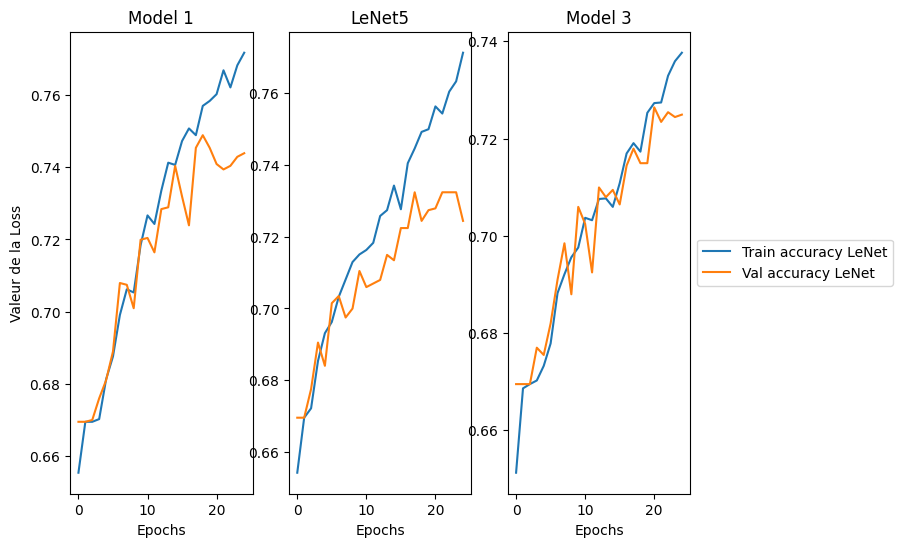

In [142]:
##Plot the two models results
# TODO: Compute the accuracy of your model
##
loss_model1 = history.history['accuracy']
val_model1 = history.history['val_accuracy']
##LeNet model
loss_LeNet = history2.history['accuracy']
val_LeNet = history2.history['val_accuracy']
##LeNet model
loss_model3 = history3.history['accuracy']
val_model3 = history3.history['val_accuracy']

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.subplot(1, 3, 1)
plt.plot(loss_model1,label = 'Train accuracy Model1')
plt.plot(val_model1, label = 'Val accuracy Model1')
plt.title("Model 1")

plt.xlabel('Epochs')
plt.ylabel('Valeur de la Loss')
plt.subplot(1, 3, 2)
plt.plot(loss_LeNet,label = 'Train accuracy LeNet')
plt.plot(val_LeNet, label = 'Val accuracy LeNet')
plt.title("LeNet5")
plt.xlabel('Epochs')
plt.ylabel('')
plt.subplot(1, 3, 3)
plt.plot(loss_model3,label = 'Train accuracy LeNet')
plt.plot(val_model3, label = 'Val accuracy LeNet')
plt.title("Model 3")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Epochs')
plt.ylabel('')
plt.savefig('Results_CNN_models.jpg', format='jpg')

###2.4 DATA AUGMENTATION WITH IMAGE DATAGENERATOR







In [75]:
##DATA AUGMENTATION
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=(0.5, 1.5),  # Adjust brightness
)



In [76]:
# Fit ImageDataGenerator object
datagen.fit(X_train)
batch_size = 32
model_1.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use categorical cross-entropy for multi-class classification
              metrics=['accuracy'])
##Create a train_generator model
train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)

####Test the three models with Data augmentation

In [ ]:
###Trying the three model with X_train modifyed with ImageGenerator
##Model1
model1_aug = model1()

model1_aug.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use categorical cross-entropy for multi-class classification
              metrics=['accuracy'])
# TODO: Compile and fit your model
callback = [EarlyStopping(monitor='accuracy', patience=10)]

history_1_aug = model1_aug.fit(train_generator,
                            validation_data=(X_test,y_test),
                            batch_size = 202,
                            epochs = 25,
                            callbacks = callback)



In [145]:
##Saving model
##Saving the model 1
# Assuming 'model' is your trained CNN model
with open('cnn_model1_aug.pkl', 'wb') as model_file:
    pickle.dump(model1_aug, model_file)

# Assuming 'model' is your trained CNN model
model1_aug.save('cnn_mode1_aug.h5')

In [ ]:
###Trying the three model with X_train modifyed with ImageGenerator
##Model2 /LeNet
lenet_aug = lenet()

##compile
lenet_aug.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use categorical cross-entropy for multi-class classification
              metrics=['accuracy'])
# TODO: Compile and fit your model
callback = [EarlyStopping(monitor='accuracy', patience=10)]

history_2_aug = lenet_aug.fit(train_generator,
                            validation_data=(X_test,y_test),
                            batch_size = 202,
                            epochs = 25,
                            callbacks = callback)


Epoch 1/25
1174/1174 [==============================] - 70s 59ms/step - loss: 1.9461 - accuracy: 0.1435 - val_loss: 4.3371 - val_accuracy: 0.6695
Epoch 2/25
1174/1174 [==============================] - 74s 63ms/step - loss: 1.9458 - accuracy: 0.1410 - val_loss: 4.3723 - val_accuracy: 0.6695
Epoch 3/25
1174/1174 [==============================] - 65s 56ms/step - loss: 1.9455 - accuracy: 0.1448 - val_loss: 1.2770 - val_accuracy: 0.6695
Epoch 4/25
1174/1174 [==============================] - 69s 59ms/step - loss: 1.9451 - accuracy: 0.1408 - val_loss: 1.2473 - val_accuracy: 0.6695
Epoch 5/25
1174/1174 [==============================] - 64s 54ms/step - loss: 1.9455 - accuracy: 0.1413 - val_loss: 1.6958 - val_accuracy: 0.6640
Epoch 6/25
1174/1174 [==============================] - 65s 55ms/step - loss: 1.9453 - accuracy: 0.1428 - val_loss: 1.8239 - val_accuracy: 0.6345
Epoch 7/25
1174/1174 [==============================] - 65s 55ms/step - loss: 1.9451 - accuracy: 0.1416 - val_loss: 1.2277 -

In [147]:
##Saving model
##Saving the model 1
# Assuming 'model' is your trained CNN model
with open('cnn_lenet_aug.pkl', 'wb') as model_file:
    pickle.dump(lenet_aug, model_file)

# Assuming 'model' is your trained CNN model
lenet_aug.save('cnn_lenet_aug.h5')

In [169]:
###Trying the three model with X_train modifyed with ImageGenerator
##Model3

model3 = model3((28, 28, 3), regul=0.0, dropout=0.25)
model3aug.summary()

##model3aug
model3aug.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use categorical cross-entropy for multi-class classification
              metrics=['accuracy'])
# TODO: Compile and fit your model

callback = [EarlyStopping(monitor='accuracy', patience=10)]

history_3_aug = model3aug.fit(train_generator,
                            validation_data=(X_test,y_test),
                            batch_size = 202,
                            epochs = 25,
                            callbacks = callback)

ValueError: ignored

In [ ]:
##Saving model
##Saving the model 3
# Assuming 'model' is your trained CNN model
with open('cnn_model3_aug.pkl', 'wb') as model_file:
    pickle.dump(model3_aug, model_file)

# Assuming 'model' is your trained CNN model
model3_aug.save('cnn_model3_aug.h5')

####Plot models results with data augmentation

In [163]:
##Plot the two models results
# TODO: Compute the accuracy of your model
##
loss_model1 = history_1_aug.history['accuracy']
val_model1 = history_1_aug.history['val_accuracy']
##LeNet model
loss_LeNet = history_2_aug.history['accuracy']
val_LeNet = history_2_aug.history['val_accuracy']
##LeNet model
loss_model3 = history_3_aug.history['accuracy']
val_model3 = history_3_aug.history['val_accuracy']

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.subplot(1, 3, 1)
plt.plot(loss_model1,label = 'Train accuracy Model1')
plt.plot(val_model1, label = 'Val accuracy Model1')
plt.title("Model 1")

plt.xlabel('Epochs')
plt.ylabel('Valeur de la Loss')
plt.subplot(1, 3, 2)
plt.plot(loss_LeNet,label = 'Train accuracy LeNet')
plt.plot(val_LeNet, label = 'Val accuracy LeNet')
plt.title("LeNet")
plt.xlabel('Epochs')
plt.ylabel('')
plt.subplot(1, 3, 3)
plt.plot(loss_model3,label = 'Train accuracy LeNet')
plt.plot(val_model3, label = 'Val accuracy LeNet')
plt.title("Model3")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Epochs')
plt.ylabel('')
plt.savefig("CNN_Results_Data_Augmentation.jpg", format='jpg')

NameError: ignored

###2.5 REBALANCING DATASET

####Balanced dataset using SMOTE frome flatten images

In [170]:
# Instantiate the SMOTE resampler
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
##Smote only work with 2 dimensions
X_resampled, y_resampled = smote.fit_resample(df, y)

# Check the class distribution after resampling
unique, counts = np.unique(y_resampled, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Class distribution after SMOTE resampling:", class_distribution)


ValueError: ignored

In [171]:
##SHAPE OF X & y
X_resampled.shape, y_resampled.shape


((46935, 28, 28, 3), (46935, 7))

####Prepared balanded data for CNN models

In [86]:
##Prepare dataset to CNN
##Reshape X to 28,28,3
original_shape = (len(X_resampled), 28, 28, 3)
X_resampled = X_resampled.to_numpy()
X_resampled = X_resampled.reshape(original_shape)
y_resampled = to_categorical(y_resampled, num_classes=7)

X_resampled.shape, y_resampled.shape

((46935, 28, 28, 3), (46935, 7))

In [87]:
##SPlit data
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_resampled, y_resampled, stratify= y_resampled, test_size=0.2, random_state=42)
X_train_resampled.shape, y_train_resampled.shape, X_test_resampled.shape, y_test_resampled.shape

((37548, 28, 28, 3), (37548, 7), (9387, 28, 28, 3), (9387, 7))

####CNN models on balanced dataset

In [176]:
##rerun model 1
##Run model
model1_balanced = model1()

model1_balanced.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use categorical cross-entropy for multi-class classification
              metrics=['accuracy'])
# TODO: Compile and fit your model
callback = [EarlyStopping(monitor='accuracy', patience=10)]

history_1_bal = model1_balanced.fit(X_train_resampled,y_train_resampled,
                            validation_data=(X_test_resampled,y_test_resampled),
                            batch_size = 202,
                            epochs = 25,
                            callbacks = callback)

Epoch 1/25
186/186 [==============================] - 41s 215ms/step - loss: 1.4567 - accuracy: 0.4151 - val_loss: 1.1608 - val_accuracy: 0.5484
Epoch 2/25
186/186 [==============================] - 43s 229ms/step - loss: 1.0649 - accuracy: 0.5913 - val_loss: 0.9860 - val_accuracy: 0.6247
Epoch 3/25
186/186 [==============================] - 40s 217ms/step - loss: 0.9278 - accuracy: 0.6504 - val_loss: 0.9783 - val_accuracy: 0.6222
Epoch 4/25
186/186 [==============================] - 41s 218ms/step - loss: 0.8351 - accuracy: 0.6907 - val_loss: 0.8059 - val_accuracy: 0.7028
Epoch 5/25
186/186 [==============================] - 41s 219ms/step - loss: 0.7516 - accuracy: 0.7237 - val_loss: 0.7354 - val_accuracy: 0.7233
Epoch 6/25
186/186 [==============================] - 42s 227ms/step - loss: 0.6778 - accuracy: 0.7531 - val_loss: 0.7038 - val_accuracy: 0.7392
Epoch 7/25
186/186 [==============================] - 41s 219ms/step - loss: 0.6105 - accuracy: 0.7769 - val_loss: 0.6202 - val_ac

In [177]:
##Saving the model 1 balanced
with open('cnn_model1_bal.pkl', 'wb') as model_file:
    pickle.dump(model1_balanced, model_file)

model1_balanced.save('cnn_model1_bal.h5')

In [174]:
###Balanced data
##Model2 /LeNet
lenet_bal = lenet()

##compile
lenet_bal.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use categorical cross-entropy for multi-class classification
              metrics=['accuracy'])
# TODO: Compile and fit your model
callback = [EarlyStopping(monitor='accuracy', patience=10)]

history_2_bal = lenet_bal.fit(X_train_resampled,y_train_resampled,
                            validation_data=(X_test_resampled,y_test_resampled),
                            batch_size = 202,
                            epochs = 25,
                            callbacks = callback)


Epoch 1/25
186/186 [==============================] - 49s 250ms/step - loss: 1.6625 - accuracy: 0.3367 - val_loss: 1.3415 - val_accuracy: 0.4781
Epoch 2/25
186/186 [==============================] - 32s 173ms/step - loss: 1.1705 - accuracy: 0.5588 - val_loss: 1.0815 - val_accuracy: 0.5925
Epoch 3/25
186/186 [==============================] - 31s 165ms/step - loss: 0.9759 - accuracy: 0.6387 - val_loss: 0.9059 - val_accuracy: 0.6685
Epoch 4/25
186/186 [==============================] - 33s 178ms/step - loss: 0.8415 - accuracy: 0.6879 - val_loss: 0.7995 - val_accuracy: 0.7001
Epoch 5/25
186/186 [==============================] - 34s 180ms/step - loss: 0.7419 - accuracy: 0.7258 - val_loss: 0.7333 - val_accuracy: 0.7265
Epoch 6/25
186/186 [==============================] - 31s 167ms/step - loss: 0.6558 - accuracy: 0.7615 - val_loss: 0.6490 - val_accuracy: 0.7609
Epoch 7/25
186/186 [==============================] - 32s 172ms/step - loss: 0.6074 - accuracy: 0.7794 - val_loss: 0.6328 - val_ac

In [175]:
##Saving the model 2 balanced
with open('cnn_lenet_bal.pkl', 'wb') as model_file:
    pickle.dump(lenet_bal, model_file)

lenet_bal.save('cnn_lenet_bal.h5')

In [180]:
##Balanced data Model 3
model3_bal = model3((28,28,3), regul=0.0, dropout=0.25)

##compile
model3_bal.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use categorical cross-entropy for multi-class classification
              metrics=['accuracy'])
# TODO: Compile and fit your model
callback = [EarlyStopping(monitor='accuracy', patience=10)]

history_3_bal = model3_bal.fit(X_train_resampled, y_train_resampled,
                            validation_data=(X_test,y_test),
                            batch_size = 202,
                            epochs = 25,
                            callbacks = callback)

ValueError: ignored

In [ ]:
##Saving the model 3 balanced
with open('cnn_model3_bal.pkl', 'wb') as model_file:
    pickle.dump(model3_bal, model_file)

model3_bal.save('cnn_model3_bal.h5')

#####Plot results of the three models with Balanced data

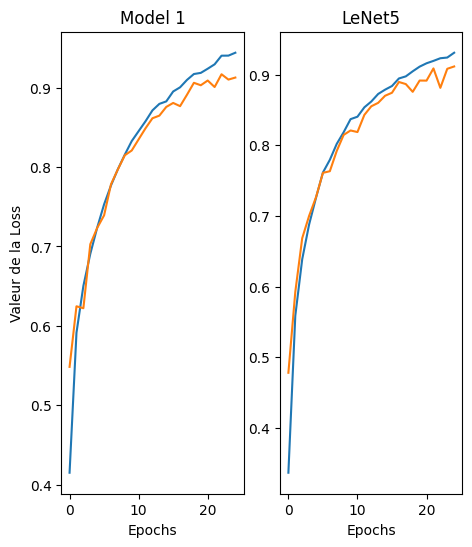

In [182]:
##Plot the two models results
# TODO: Compute the accuracy of your model
##
loss_model1 = history_1_bal.history['accuracy']
val_model1 = history_1_bal.history['val_accuracy']
##LeNet model
loss_LeNet = history_2_bal.history['accuracy']
val_LeNet = history_2_bal.history['val_accuracy']
##LeNet model
#loss_model3 = history_3_bal.history['accuracy']
#val_model3 = history_3_bal.history['val_accuracy']

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.subplot(1, 3, 1)
plt.plot(loss_model1,label = 'Train accuracy Model1')
plt.plot(val_model1, label = 'Val accuracy Model1')
plt.title("Model 1")

plt.xlabel('Epochs')
plt.ylabel('Valeur de la Loss')
plt.subplot(1, 3, 2)
plt.plot(loss_LeNet,label = 'Train accuracy LeNet')
plt.plot(val_LeNet, label = 'Val accuracy LeNet')
plt.title("LeNet5")
plt.xlabel('Epochs')
plt.ylabel('')
#plt.subplot(1, 3, 3)
#plt.plot(loss_model3,label = 'Train accuracy LeNet')
#plt.plot(val_model3, label = 'Val accuracy LeNet')
#plt.title("Model3")
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.xlabel('Epochs')
#plt.ylabel('')
plt.savefig("CNN_Results_Balanced_data.jpg", format='jpg')

###2.6 CNN MODELING WITH BALANCED DATASET AND AUGMENTATION

In [183]:
# Fit ImageDataGenerator object
datagen.fit(X_train_resampled)
batch_size = 32

##Create a train_generator model
train_generator = datagen.flow(X_train_resampled, y_train_resampled, batch_size=batch_size)

In [184]:
##Run on Model1
##Model1
##Run model
model1_aug_bal = model1()

model1_aug_bal.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use categorical cross-entropy for multi-class classification
              metrics=['accuracy'])
# TODO: Compile and fit your model
callback = [EarlyStopping(monitor='accuracy', patience=10)]

history_1_bal_aug = model1_aug_bal.fit(train_generator,
                            validation_data=(X_test,y_test),
                            batch_size = 202,
                            epochs = 25)



Epoch 1/25
1174/1174 [==============================] - 108s 90ms/step - loss: 1.9477 - accuracy: 0.1395 - val_loss: 1.8498 - val_accuracy: 0.2611
Epoch 2/25
1174/1174 [==============================] - 76s 65ms/step - loss: 1.9463 - accuracy: 0.1445 - val_loss: 1.2314 - val_accuracy: 0.6695
Epoch 3/25
1174/1174 [==============================] - 75s 64ms/step - loss: 1.9456 - accuracy: 0.1453 - val_loss: 2.6433 - val_accuracy: 0.6695
Epoch 4/25
1174/1174 [==============================] - 77s 66ms/step - loss: 1.9458 - accuracy: 0.1399 - val_loss: 1.4244 - val_accuracy: 0.6695
Epoch 5/25
1174/1174 [==============================] - 76s 65ms/step - loss: 1.9450 - accuracy: 0.1411 - val_loss: 1.8654 - val_accuracy: 0.2931
Epoch 6/25
1174/1174 [==============================] - 75s 64ms/step - loss: 1.9452 - accuracy: 0.1393 - val_loss: 1.4320 - val_accuracy: 0.6695
Epoch 7/25
1174/1174 [==============================] - 75s 64ms/step - loss: 1.9455 - accuracy: 0.1413 - val_loss: 3.9030 

In [ ]:
##Saving the model 3 balanced
with open('cnn_model1_aug_bal.pkl', 'wb') as model_file:
    pickle.dump(model1_aug_bal, model_file)

model1_aug_bal.save('cnn_model1_aug_bal.h5')

####2.7 Choosing the right Model
Model 1 with data augmented seems the best model for prediction we will plot the confusion matrices for test & train with Model1 without and with data augmentation.

###3.MACHINE LEARNING : SUPERVIZED ML FOR PREDICTION







####3.1 Prepare flatten images dataset

In [99]:
###IF WE WANT TO RESTART FROM THE FLATTEN CSV FILE
# Load the CSV file containing flattened image data and labels.
df = pd.read_csv('/content/skin_cancer_dataset/image_scaled_flatten.csv')

# Extract flattened image data and labels.
y = df['y'].values
df = df.drop('Unnamed: 0', axis=1)
df = df.drop('labels_id', axis=1)
X = df

In [1]:
##Train test split
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(X, y, stratify= y, test_size=0.2, random_state=42)
X_train_ml.shape, y_train_ml.shape, X_test_ml.shape, y_test_ml.shape


NameError: ignored

####3.2 Run Models

####Logistic Regression

In [101]:
##LR
lr = LogisticRegression()
lr.fit(X_train_ml, y_train_ml)
acc_lr= accuracy_score(y_test_ml, lr.predict(X_test_ml))
acc_lr

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9256115826260609

#####K Neighbors classifier

In [102]:
##KNN
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=10)
knn_model.fit(X_train_ml, y_train_ml)
acc_knn= accuracy_score(y_test_ml, knn_model.predict(X_test_ml))
acc_knn

0.8242636045931103

####Linear Discriminant Analysis

In [103]:
###Linear Discriminant Analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train_ml, y_train_ml)
acc_lda= accuracy_score(y_test_ml, lda_model.predict(X_test_ml))
acc_lda

0.6205691462805791

####SVM

In [104]:
##SVM model
from sklearn import svm
svm = svm.SVC(kernel='linear')
svm.fit(X_train_ml, y_train_ml)
acc_svm = accuracy_score(y_test_ml, svm.predict(X_test_ml))


In [ ]:
acc_svm

1.0

####Random forest

In [105]:
###Random Forest
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X_train_ml, y_train_ml)
acc_rf = accuracy_score(y_test_ml, clf.predict(X_test_ml))
acc_rf

0.7793310034947578

###3.3 Results from Linear Models

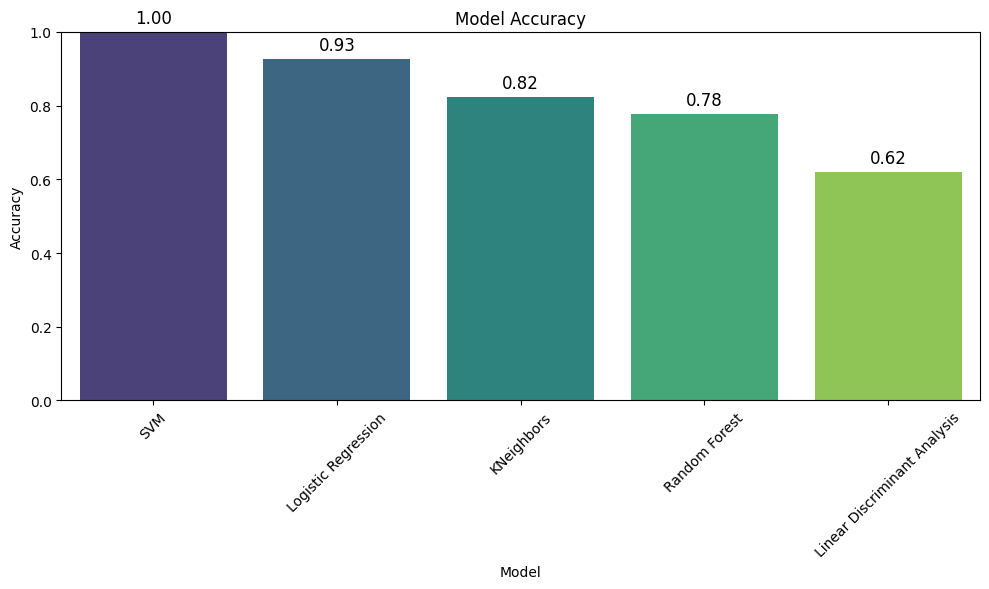

<Figure size 640x480 with 0 Axes>

In [107]:
##BARPLOT
data = {
    'Model': ['Logistic Regression', 'KNeighbors', 'Linear Discriminant Analysis', 'SVM', 'Random Forest'],
    'Accuracy': [0.9256, 0.8242, 0.6205, 1, 0.7783]
}
df = pd.DataFrame(data)
# Sort the DataFrame by accuracy in descending order
df = df.sort_values(by='Accuracy', ascending=False)

# Create the bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Model', y='Accuracy', data=df, palette='viridis')

# Add data labels
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                textcoords='offset points')

plt.title('Model Accuracy')
plt.ylim(0, 1.0)  # Set y-axis limits
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

plt.show()
plt.savefig("Results_ML_images_analysis.jpg", format='jpg')

In [ ]:
##Plotting confusion test and train matrices from SVM
from sklearn.metrics import confusion_matrix

# Predictions on the train and test datasets
conf_matrix_test_svm = confusion_matrix(y_test_ml, svm.predict(X_test_ml))
conf_matrix_train_svm = confusion_matrix(y_train_ml, svm.predict(X_train_ml))

class_labels_text =['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

# Plot the confusion matrix for the training dataset
plt.subplot(2, 1, 1)
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix_train_svm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels_text, yticklabels=class_labels_text)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix SVM (Train)")

# Plot the confusion matrix for the test dataset
plt.subplot(2, 1, 2)
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix_test_svm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels_text, yticklabels=class_labels_text)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix SVM (Test)")

plt.tight_layout()
plt.show()


##3.4. Saving ML models for predictions

####Saving ML models

In [111]:
##Saving with pickle in .sav
import pickle
pickle.dump(lr, open(f"model_lr_Image_Analysis.sav", "wb"))
pickle.dump(lda_model, open(f"model_lda_Image_Analysis.sav", "wb"))
pickle.dump(knn_model, open(f"model_knn_Image_Analysis.sav", "wb"))
pickle.dump(clf, open(f"model_rf_Image_Analysis.sav", "wb"))
pickle.dump(svm, open(f"model_svm_Image_Analysis.sav", "wb"))


In [112]:
###Latter one to predict on a new data
# Save the trained model to a file using pickle
with open('model_lr_Image_Analysis.pkl', 'wb') as file:
    pickle.dump(lr, file)

with open('model_lda_Image_Analysis.pkl', 'wb') as file:
    pickle.dump(lda_model, file)

with open('model_knn_Image_Analysis.pkl', 'wb') as file:
    pickle.dump(knn_model, file)

with open('model_rf_Image_Analysis.pkl', 'wb') as file:
    pickle.dump(clf, file)

with open('model_svm_Image_Analysis.pkl', 'wb') as file:
    pickle.dump(svm, file)


####Testing ML the model

In [ ]:
# Later, you can load the model from the file and use it for predictions
with open('logistic_regression_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Example usage: Make predictions with the loaded model
new_data = [[5.1, 3.5, 1.4, 0.2]]  # Replace with your own data
predictions = loaded_model.predict(new_data)
print(predictions)

In [ ]:
###Function to import pictures and run preduction

# Define the class labels for the CNN models
cnn_model_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

# Define the class labels for the linear models
linear_model_labels = ['Logistic Regression', 'KNeighbors', 'Linear Discriminant Analysis', 'SVM', 'Random Forest']

def import_and_predict(image_path):
    try:
        # Load and preprocess the image
        image = cv2.imread(image_path)
        image = cv2.resize(image, (28, 28))
        image = image / 255.0  # Normalize pixel values (assuming 0-255 scale)
        image = np.expand_dims(image, axis=0)  # Add a batch dimension

        # Load and predict using the CNN models
        cnn_predictions = []
        for model_file in ['cnn_model1.pkl', 'cnn_model2.pkl', 'cnn_model3.pkl']:
            with open(model_file, 'rb') as file:
                cnn_model = pickle.load(file)
            cnn_prediction = cnn_model.predict(image)
            cnn_predictions.append(cnn_prediction[0])

        # Load and predict using the linear models
        linear_predictions = []
        for model_file in ['logistic_regression_model.pkl', 'kneighbors_model.pkl',
                           'lda_model.pkl', 'svm_model.pkl', 'random_forest_model.pkl']:
            with open(model_file, 'rb') as file:
                linear_model = pickle.load(file)
            image_flattened = image.reshape(1, -1)
            linear_prediction = linear_model.predict(image_flattened)
            linear_predictions.append(linear_prediction[0])

        return cnn_predictions + linear_predictions

    except Exception as e:
        return str(e)

# Example usage:
image_path = 'path_to_your_image.jpg'  # Replace with the path to your image
results = import_and_predict(image_path)
print("CNN Model 1 Prediction:", cnn_model_labels[results[0]])
print("CNN Model 2 Prediction:", cnn_model_labels[results[1]])
print("CNN Model 3 Prediction:", cnn_model_labels[results[2]])
print("Logistic Regression Prediction:", linear_model_labels[results[3]])
print("KNeighbors Prediction:", linear_model_labels[results[4]])
print("Linear Discriminant Analysis Prediction:", linear_model_labels[results[5]])
print("SVM Prediction:", linear_model_labels[results[6]])
print("Random Forest Prediction:", linear_model_labels[results[7]])